In [96]:
import pandas as pd
from modules.fetcher import Fetcher
import matplotlib.pyplot as plt

fetcher = Fetcher()

In [97]:
now = pd.Timestamp.now().tz_localize(None)
start = pd.Timestamp('2023-05-01 00:00:00').tz_localize(None)

leverages = [1, 2, 5, 10]
fee = 0.001
penalty = 0.01
maintenance_margin = 0.05 # 5%
stop_loss_margin = maintenance_margin * (1 + 0.25)

In [98]:
def get_backtest_result(input_df, l):
    df = input_df.copy()
    for index, row in enumerate(df.iterrows()):
        if index == 0:
            df['clt'] = 1
            df['leverage'] = l
            df['entry'] = 0
            df['pos_size'] = 0
            df['change'] = 0
            df['change_pnl'] = 0
            df['funding'] = 0
            df['funding_pnl'] = 0
            df['margin'] = 0

            df['mm'] = df['clt'] * df['leverage'] * maintenance_margin
            df['mm_sl'] = df['clt'] * df['leverage'] * stop_loss_margin

            df['is_liq'] = False
            df['is_sl'] = False

            df['fee'] = -fee * df['leverage']
            df['penalty'] = 0
            df['final_pnl'] = 0
        else:
            prev_df = df.loc[index - 1]
            traded = prev_df['fee'] != 0

            new_clt = prev_df['clt'] + prev_df['fee'] + prev_df['penalty'] + (prev_df['funding_pnl'] if traded else 0)
            
            price = float(df.loc[index, 'close'])
            funding_rate = float(df.loc[index, 'funding_rate'])

            df.loc[index, 'clt'] = max(new_clt, 0)
            df.loc[index, 'entry'] = price if traded else prev_df['entry']
            df.loc[index, 'pos_size'] = price * df.loc[index, 'clt'] * df.loc[index, 'leverage']
            df.loc[index, 'change'] = (price - df.loc[index, 'entry']) / df.loc[index, 'entry'] if df.loc[index, 'entry'] != 0 else 0
            df.loc[index, 'change_pnl'] = -abs(df.loc[index, 'change'] * df.loc[index, 'leverage'])
            df.loc[index, 'funding'] = funding_rate * df.loc[index, 'leverage'] / 2
            df.loc[index, 'funding_pnl'] = df.loc[index, 'funding'] if traded else df.loc[index, 'funding'] + df.loc[index - 1, 'funding_pnl']
            df.loc[index, 'margin'] = (df.loc[index, 'clt'] + df.loc[index, 'change_pnl'] + df.loc[index, 'funding_pnl']) / df.loc[index, 'clt'] if df.loc[index, 'clt'] != 0 else 0

            df.loc[index, 'mm'] = df.loc[index, 'clt'] * df.loc[index, 'leverage'] * maintenance_margin
            df.loc[index, 'mm_sl'] = df.loc[index, 'clt'] * df.loc[index, 'leverage'] * stop_loss_margin

            df.loc[index, 'is_liq'] = df.loc[index, 'margin'] < df.loc[index,'mm']
            df.loc[index, 'is_sl'] = df.loc[index, 'margin'] < df.loc[index, 'mm_sl']

            df.loc[index, 'fee'] = -fee * df.loc[index, 'leverage'] if df.loc[index, 'is_liq'] or df.loc[index, 'is_sl'] else 0
            df.loc[index, 'penalty'] = -fee * df.loc[index, 'leverage'] if df.loc[index, 'is_liq'] else 0
            df.loc[index, 'final_pnl'] = df.loc[index, 'clt'] - 1 + df.loc[index, 'funding_pnl']
    return df

In [99]:
def get_hodl_result(input_df):
    df = input_df.copy()
    df = df.sort_values(by='datetime', ascending=True)
    df = df.reset_index(drop=True)
    df['close'] = df['close'].astype(float)
    first_price = df.loc[0, 'close']
    df['pnl'] = (df['close'] - first_price) / first_price
    return df

Drift XRP-PERP Error: 403
Drift XRP-PERP Error: 403


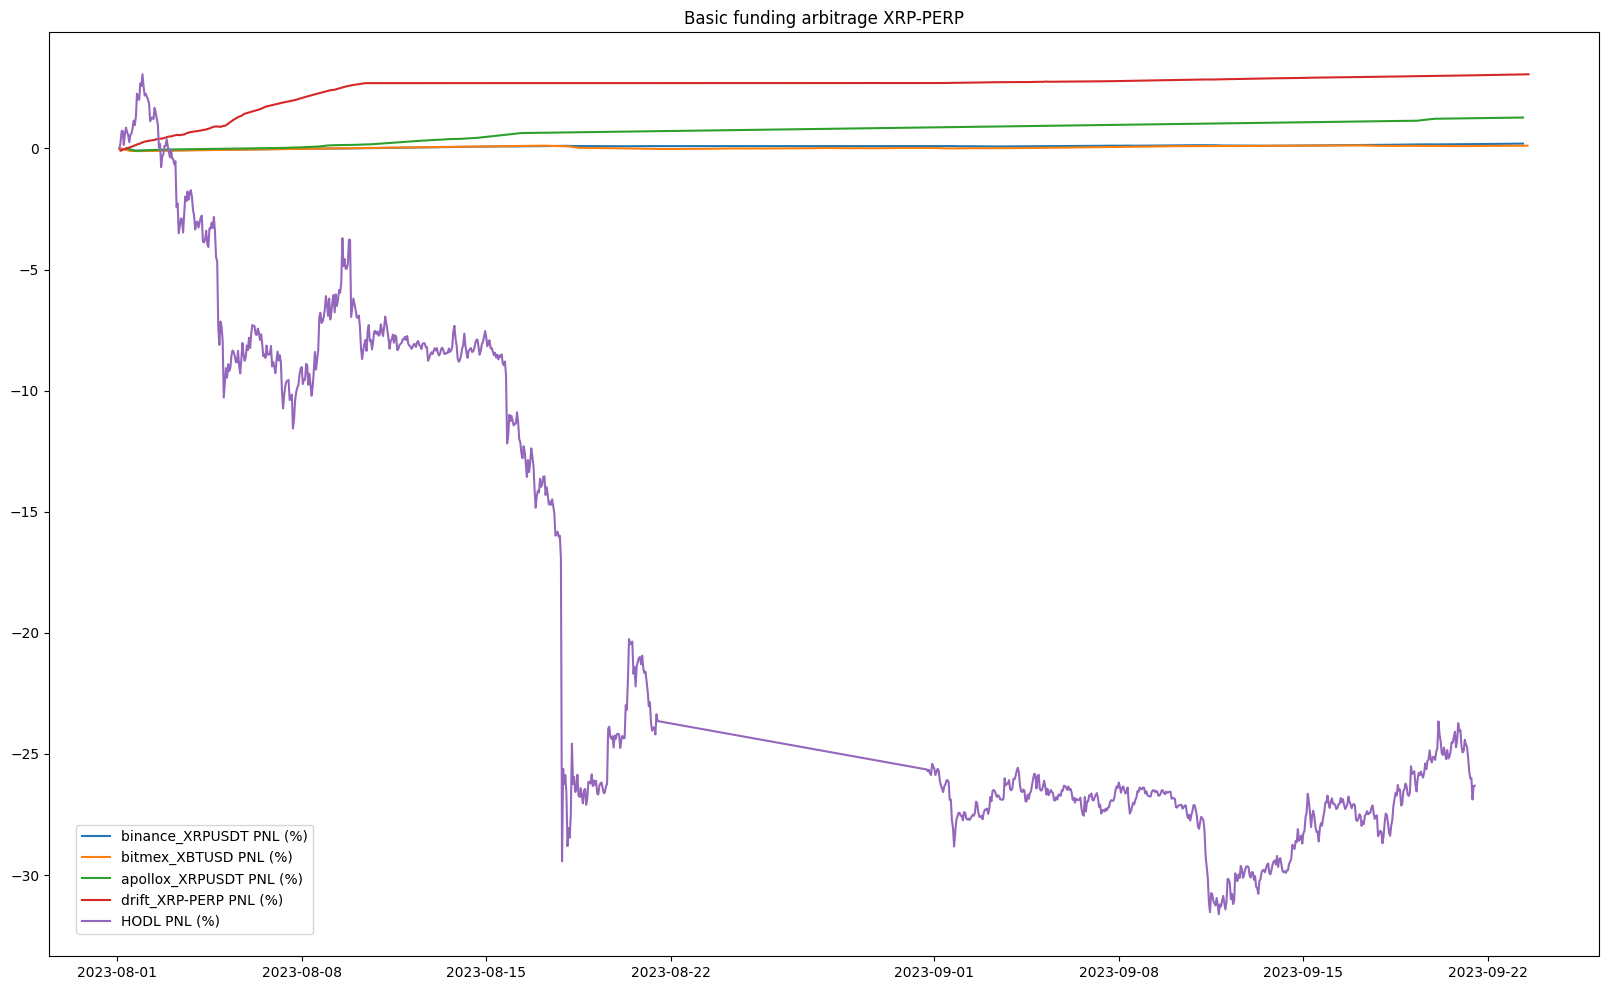

In [103]:
from datetime import datetime

# Input
exchanges_market = {
    "binance": "XRPUSDT",
    "bitmex": "XBTUSD",
    "apollox": "XRPUSDT",
    "drift": "XRP-PERP"
}
benchmark_exchange = "binance"
benchmark_market = exchanges_market[benchmark_exchange]

# Initial variables
min_time = 0
max_time = datetime.now().timestamp()
funding_df_map = {}
price_df_map = {}
results = {}

# Plot setup
fig, ax = plt.subplots(figsize=(20, 12))

# Fetch all funding rates and check date range
for exchange, market in exchanges_market.items():
    funding_df = fetcher.fetch_funding_rate_history_until_start(exchange, market)

    start_funding_time = funding_df['timestamp'].min()
    end_funding_time = funding_df['timestamp'].max()

    price_df = fetcher.fetch_ohlc(exchange, market, start_funding_time, end_funding_time)
    price_df['datetime'] = price_df['datetime'].dt.tz_localize(None)

    start_price_time = price_df['timestamp'].min()
    end_price_time = price_df['timestamp'].max()

    # Save result
    min_time = max(min_time, start_funding_time, start_price_time)
    max_time = min(max_time, end_funding_time, end_price_time)

    funding_df_map[exchange] = funding_df
    price_df_map[exchange] = price_df

min_datetime = pd.to_datetime(min_time, unit='s')
max_datetime = pd.to_datetime(max_time, unit='s')

# Fetch price data and calculate backtest result
for exchange, market in exchanges_market.items():
    funding_df = funding_df_map[exchange]
    price_df = price_df_map[exchange]

    funding_df = funding_df[(funding_df['datetime'] >= min_datetime) & (funding_df['datetime'] <= max_datetime)]
    price_df = price_df[(price_df['datetime'] >= min_datetime) & (price_df['datetime'] <= max_datetime)]

    funding_df = funding_df.reset_index(drop=True)
    price_df = price_df.reset_index(drop=True)

    input_df = pd.merge_asof(funding_df, price_df, on=['datetime'], tolerance=pd.Timedelta('1h'), direction='nearest')
    result_df = get_backtest_result(input_df, 1)

    results[exchange] = result_df

for exchange, market in exchanges_market.items():
    result_df = results[exchange]
    ax.plot(result_df['datetime'], result_df['final_pnl'] * 100, label=f'{exchange}_{market} PNL (%)')

# Hodl result
price_df = fetcher.fetch_ohlc(benchmark_exchange, benchmark_market, min_time, max_time)
price_df = price_df[(price_df['datetime'] >= min_datetime) & (price_df['datetime'] <= max_datetime)]
price_df = price_df.reset_index(drop=True)

hodl_df = get_hodl_result(price_df)
hodl_df['datetime'] = hodl_df['datetime'].dt.tz_localize(None)

ax.plot(hodl_df['datetime'], hodl_df['pnl'] * 100, label=f'HODL PNL (%)')

# Chart settings
lines, labels = ax.get_legend_handles_labels()
ax.set_title(f"Basic funding arbitrage {market.split(':')[0]}")
ax.legend(lines, labels, loc='upper right', bbox_to_anchor=(0.175, 0.15))

plt.show()